# Python Document Search Engine

Now, we will start to put together all of the topics that we have studied so far into a series of "Python Recipes"---coding examples that illustrate the power of thinking hard about how data is organized and structured. In the first example, we will consider a "Python Search Engine" that will identify relevant items given a query string.

We're going to start with a dataset of tweets about airlines:

In [2]:
import csv

def load_data(filename):
    rtn = []
    #open the file with the csv reader
    with open(filename, newline='') as csvfile:
        tweets = csv.reader(csvfile, delimiter=',', quotechar='"') 
        next(tweets)       #skip the header   
        for row in tweets:
            rtn.append(row[10])
    return rtn

tweets = load_data('Tweets.csv')

#figure out how much data we have
size = sum([i.__sizeof__() for i in tweets]) + tweets.__sizeof__()

print('Number: ', len(tweets), '\t Size:', size/1e6,'MB','\t Bytes per tweet:', size/len(tweets))

Number:  14640 	 Size: 2.416432 MB 	 Bytes per tweet: 165.05683060109288


In [4]:
tweets

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica plus you've added commercials to the experience... tacky.",
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24',
 '@VirginAmerica I &lt;3 pretty graphic

This dataset contains a large list of tweets represented as string. We want to be able to search for phrases in these tweets. Of course, the first thing that we can do is the simple naive search routine where we scan through the entire dataset.

## Naive Search
Suppose, we wanted to find a substring in this collection of tweets, we could write the following code that iterates through each tweet and searches for a substring:

In [6]:
import datetime

def find(phrase, tweets):
    #Naive full scan approach
    start = datetime.datetime.now()
    rtn = []    
    for t in tweets:
        if phrase in t:
            rtn.append(t)
    print('Find() elapsed time: ', (datetime.datetime.now()-start).total_seconds())          
    return rtn


find('choppy landing', tweets)

find('LAX', tweets)

Find() elapsed time:  0.002413
Find() elapsed time:  0.002937


["@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 '@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix',
 '@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!',
 '@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️',
 '@VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin',
 '@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM',
 '@VirginAmerica Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃',
 '@VirginAmerica congrats, you just got all my business from EWR to SFO/LAX. Fuck you @united fl1289 SFO/EWR was the cl

In [10]:
find("Landed at JFK", tweets)

Find() elapsed time:  0.002055


[]

In [12]:
find("us a flt out", tweets)

Find() elapsed time:  0.002595


['@VirginAmerica Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃']

That's pretty fast (5  ms!) But imagine if you had to run a million of such lookups, that would be 5000 seconds! At scale, small overheads add up. 

Now, we use our "inverted indexing" trick to make such searches faster.

## Inverted Index
Next, we will try to do the same search with an inverted index. The indexing structure that we will use is a python dictionary.

In [14]:
import string 

def build_index(tweets):
    start = datetime.datetime.now() 
    index = {}
    
    #some code to deal with punctuation
    table = str.maketrans('', '', string.punctuation)
    for i, t in enumerate(tweets):      
        words = t.translate(table).split()       
        for w in words:         
            if w not in index:
                index[w] = set()          
            index[w].add(i) #add a pointer to the relevant tweet       
    print('build_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())      
    return index

index = build_index(tweets)

build_index() elapsed time:  0.303587


Notice that build_index is about a 100x slower than a single query. What does this mean? Basically, indexing is only valuable if you run a lot of queries! 

The next challenge is how to use an inverted index to answer general substring queries. In class, we showed how to do exact keyword lookup but the phrase 'choppy landing' is actually two words. This is actually not a problem, and we can use the inverted index to retrieve a set of candidates and then use the naive find method among just those candidates.

So, let's write a new find function that can use this index:
* It splits the phrase into its constituent words
* Searches each word in the inverted index, finds a set of possibly relevant tweets (that match on a single word)
* Then double checks that set.

In [16]:
index["here"]

{93,
 143,
 398,
 432,
 588,
 630,
 704,
 729,
 739,
 754,
 765,
 785,
 865,
 896,
 927,
 934,
 969,
 984,
 1096,
 1224,
 1257,
 1294,
 1458,
 1461,
 1537,
 1584,
 1705,
 1708,
 1838,
 1846,
 1930,
 1989,
 2071,
 2181,
 2211,
 2242,
 2251,
 2266,
 2274,
 2333,
 2394,
 2455,
 2458,
 2585,
 2888,
 2935,
 3063,
 3141,
 3207,
 3217,
 3263,
 3283,
 3290,
 3426,
 3437,
 3439,
 3524,
 3570,
 3618,
 3645,
 3700,
 3727,
 3742,
 3829,
 3856,
 3865,
 3944,
 3962,
 4126,
 4128,
 4143,
 4148,
 4180,
 4190,
 4234,
 4532,
 4596,
 4600,
 4614,
 4623,
 4742,
 4812,
 4932,
 5086,
 5171,
 5182,
 5212,
 5219,
 5224,
 5262,
 5268,
 5331,
 5379,
 5390,
 5429,
 5450,
 5469,
 5470,
 5488,
 5495,
 5528,
 5624,
 5648,
 5747,
 5801,
 5917,
 6048,
 6196,
 6290,
 6343,
 6363,
 6433,
 6475,
 6554,
 6680,
 6742,
 6750,
 6800,
 6823,
 6856,
 6891,
 7162,
 7242,
 7285,
 7317,
 7362,
 7375,
 7537,
 7682,
 7685,
 7699,
 7717,
 7743,
 7756,
 7767,
 7810,
 7812,
 7899,
 7972,
 8163,
 8224,
 8227,
 8232,
 8268,
 8371,
 857

In [22]:
tweets[93]

'@VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin'

In [ ]:
len(index["landed"]), len(index["Chicago"]), len(index["in"])

In [24]:
len(index)

20042

In [30]:
index["choppy"], index["landing"]

({302},
 {178,
  206,
  302,
  1435,
  1765,
  2094,
  2199,
  2238,
  2277,
  2451,
  2473,
  2665,
  2698,
  2786,
  2831,
  2916,
  3157,
  3254,
  3654,
  4258,
  4342,
  4603,
  4949,
  5447,
  5490,
  5779,
  5815,
  6307,
  6347,
  6420,
  6671,
  6822,
  6876,
  7249,
  7397,
  7400,
  7531,
  7538,
  7877,
  8239,
  9336,
  9550,
  9696,
  9879,
  10317,
  10950,
  11167,
  11272,
  11314,
  11992,
  12153,
  12390,
  12967,
  13069,
  13153,
  13423,
  13440,
  13699,
  14625})

In [36]:
def find_index(phrase, tweets, index):
    start = datetime.datetime.now()
    words = phrase.split()
    #find tweets that contain all words
    candidates = None
    
    for w in words: #for each words in the phrase
        try:
            if candidates is None:
                candidates = index[w] #return the set of tweets for w
            else:
                candidates = candidates.intersection(index[w])
        except KeyError:
            return []
    
    candidate_tweets = [tweets[ref] for ref in candidates]
    return find(phrase, candidate_tweets)
    print('find_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
    
find_index('choppy landing', tweets, index)
find_index('LAX', tweets, index)[:10]

Find() elapsed time:  4e-06
Find() elapsed time:  3.6e-05


["@united is doing musicians real dirty at LAX. I've never been blocked from getting on a flight with my bass.",
 "@United I'm hoping we don't miss our LAX - ITO connection. Not looking forward to being stuck at LAX overnight with our team....AGAIN!",
 "@united I forgot that Intl flights out of LAX don't go from Intl Terminal! Easiest re-check in ever! woo!",
 "@united - you sure missed the mark on tonight's redeye from LAX to Chicago. What a mess! You can do better!",
 "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 '@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix',
 '@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!',
 "@USAirways I have been doing that all day. Can't find my bag anywhere bc they're saying it was never scanned &amp; technically never left LAX.",

In essence, you are paying a small upfront cost for greatly improved find performance (nearly a 1000x faster!). Speed is only aspect of search engine performance. We also like to support situations where a user mistypes a phrase. For example, if we mistype choppy landing:

In [38]:
find_index('chopy landing', tweets, index)

[]

In [ ]:
find_index('choppy landing', tweets, index)




In [76]:
histo = [ (len(y), x) for x,y in index.items()]
histo

[(492, 'VirginAmerica'),
 (195, 'What'),
 (1, 'dhepburn'),
 (166, 'said'),
 (45, 'plus'),
 (39, 'youve'),
 (20, 'added'),
 (5, 'commercials'),
 (6286, 'to'),
 (4629, 'the'),
 (193, 'experience'),
 (1, 'tacky'),
 (3964, 'I'),
 (186, 'didnt'),
 (380, 'today'),
 (8, 'Must'),
 (55, 'mean'),
 (457, 'need'),
 (257, 'take'),
 (228, 'another'),
 (199, 'trip'),
 (420, 'its'),
 (226, 'really'),
 (3, 'aggressive'),
 (2, 'blast'),
 (2, 'obnoxious'),
 (23, 'entertainment'),
 (2245, 'in'),
 (1428, 'your'),
 (4, 'guests'),
 (3, 'faces'),
 (577, 'amp'),
 (517, 'they'),
 (1488, 'have'),
 (66, 'little'),
 (5, 'recourse'),
 (3187, 'and'),
 (3665, 'a'),
 (53, 'big'),
 (153, 'bad'),
 (68, 'thing'),
 (474, 'about'),
 (1554, 'it'),
 (49, 'seriously'),
 (481, 'would'),
 (124, 'pay'),
 (120, '30'),
 (2839, 'flight'),
 (3558, 'for'),
 (185, 'seats'),
 (1333, 'that'),
 (1130, 'this'),
 (8, 'playing'),
 (286, 'only'),
 (285, 'flying'),
 (7, 'VA'),
 (156, 'yes'),
 (13, 'nearly'),
 (93, 'every'),
 (709, 'time'),
 (

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

(array([1.2236e+04, 2.4470e+03, 1.1820e+03, 6.5900e+02, 4.3300e+02,
        3.4100e+02, 2.5800e+02, 2.1800e+02, 1.5900e+02, 1.6100e+02,
        1.1600e+02, 1.0500e+02, 1.0500e+02, 9.4000e+01, 6.5000e+01,
        6.8000e+01, 5.8000e+01, 5.0000e+01, 5.3000e+01, 3.8000e+01,
        4.1000e+01, 3.1000e+01, 3.4000e+01, 4.0000e+01, 2.9000e+01,
        2.5000e+01, 2.6000e+01, 2.4000e+01, 2.9000e+01, 1.9000e+01,
        2.2000e+01, 1.7000e+01, 1.8000e+01, 2.0000e+01, 1.6000e+01,
        1.5000e+01, 1.8000e+01, 1.6000e+01, 1.2000e+01, 9.0000e+00,
        8.0000e+00, 1.5000e+01, 2.3000e+01, 1.8000e+01, 9.0000e+00,
        8.0000e+00, 1.0000e+01, 6.0000e+00, 1.2000e+01]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48

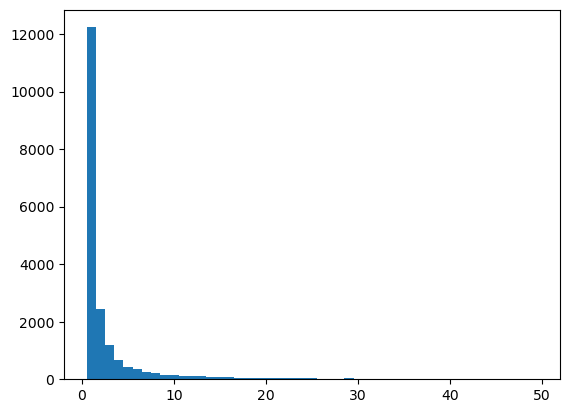

In [104]:
h = [ x for x,y in histo]
plt.hist(h, bins = np.arange(0.5, 50))

In [100]:
sorted(list(index.keys()))

['0',
 '00',
 '0011',
 '0016',
 '006',
 '0162389030167',
 '0162424965446',
 '0162431184663',
 '0167560070877',
 '0214',
 '021mbps',
 '022015',
 '0223',
 '02272015',
 '02282015',
 '03',
 '0303',
 '03032015',
 '0316',
 '0372389047497',
 '0400',
 '0510',
 '0530',
 '0600',
 '0638',
 '0671',
 '0736',
 '0769',
 '0xjareds',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '10000lbs',
 '1000cost',
 '1000p',
 '1000pm',
 '1001',
 '1001pm',
 '1002',
 '1005am',
 '1005pm',
 '1007',
 '1007p',
 '1008',
 '100PM',
 '100s',
 '101',
 '1010',
 '101030',
 '1014am',
 '1015',
 '1015am',
 '1016',
 '1019',
 '102',
 '1020',
 '1020pm',
 '10215',
 '1024',
 '1025',
 '1027',
 '1028',
 '103',
 '1030',
 '1030a',
 '1030pm',
 '1031',
 '1032',
 '1035',
 '1038',
 '1039',
 '104',
 '1041',
 '1045',
 '1045pm',
 '1046',
 '105',
 '1050',
 '1050AM',
 '1051',
 '1051pm',
 '1055',
 '1055pm',
 '1058',
 '106',
 '1065',
 '1071',
 '1074',
 '1079871763',
 '108',
 '1080',
 '1081',
 '1086',
 '108639',
 '1089',
 '1098',
 '1099',
 '10A',
 '10AM',

In [ ]:
len(index.keys())

Our system returns nothing. Can we write a fast suggestion utility that can quickly identify typos.

## Did you mean? 
So now we are going to write a utility that can identify mispelling and typos and suggest potential alternatives. So let's start off with a naive approach that simply finds the closest word in the index in terms of edit distance:

In [ ]:
#! conda install -y Distance

In [48]:
import distance

print( "Jaccard('a b', 'b c')=", distance.jaccard('a b', 'b c'))
print( "Levenshtein('a b', 'b c')=", distance.levenshtein('a b','b c') )

Jaccard('a b', 'b c')= 0.5
Levenshtein('a b', 'b c')= 2


In [62]:
def did_you_mean_naive(word, index):
    start = datetime.datetime.now()
    if word in index:
        return word
    else:
        distances = [(distance.levenshtein(word, iw), iw) for iw in index]
        distances.sort()
        print('did_you_mean_naive() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
        for i in range(10):
            print(distances[i][0], distances[i][1])
        return distances[0][1]
    
    

did_you_mean_naive('chopy', index)

did_you_mean_naive() elapsed time:  0.640285
1 choppy
1 copy
2 Ahoy
2 chips
2 chose
2 cop
2 copay
2 cozy
2 holy
2 hop


'choppy'

In [88]:
did_you_mean_naive('qwertyuiiopp', index)

did_you_mean_naive() elapsed time:  1.533011
7 question
7 questions
8 Certificate
8 Everyone
8 Everything
8 Mention
8 Operations
8 Puerto
8 Question
8 Questions


'question'

In [90]:
word_index["hop"]

{'Shopping',
 'choppiest',
 'choppy',
 'donthavehighhopes',
 'grasshopper',
 'hop',
 'hope',
 'hoped',
 'hopeful',
 'hopefully',
 'hopeidonotgetsick',
 'hopeless',
 'hopes',
 'hopethegearmakesitintact',
 'hopetogetanswersoon',
 'hopin',
 'hoping',
 'hopingpraying',
 'hopped',
 'hops',
 'ihop',
 'nothinghoping',
 'shopping'}

In [92]:
did_you_mean_naive('spel', index)

did_you_mean_naive() elapsed time:  0.399331
1 spec
1 spell
2 Aspen
2 Feel
2 Opal
2 Open
2 Tel
2 aspen
2 del
2 feel


'spec'

In [54]:
did_you_mean_naive('asdkendskd', index)

did_you_mean_naive() elapsed time:  0.781944


'addressed'

In [94]:
did_you_mean_naive("word", index)

'word'

In [96]:
did_you_mean_naive("virginamericAR", index)

did_you_mean_naive() elapsed time:  1.307145
2 virginamerica
3 virginAmerica
4 VirginAmerica
5 virginmedia
5 “VirginAmerica
5 😂VirginAmerica
6 latinamerican
7 Panamerican
7 onlyinAmerica
7 virginatlantic


'virginamerica'

In [ ]:
did_you_mean_naive('discont', index)

In [ ]:
did_you_mean_naive('arival', index)

In [ ]:
len(index.keys())

The suggestion utility runs much slower than the actual query!!! How do we fix this? We can use the same trick as before: a fast algorithm to find reasonable candidates and a slower algorithm to refine those candidates.

In fact, we will use an inverted index again. Just this time over sub-sequences of letters and not words. The first thing that we are going to do is to calculate n-grams these are contiguous sub-sequences of letters.

In [56]:
#ngram
#def find_ngrams(word, n):
#    return list(zip(*[word[i:] for i in range(n)]))

def find_ngrams(word, n):
    '''digest a word (a string) into a list of len(word)-n+1 
    ngrams of length n.'''
    return [word[i:i+n] for i in range(0, len(word)-n+1)]

find_ngrams('dave', 2)

['da', 'av', 've']

Next, we are going to build a "word" index, an indexing structure that maps ngrams to words that contain them.

In [58]:
def build_word_index(index, n):
    '''Builds a dictionary that maps ngrams contained in the 
    keys of index to the keys themselves.'''
    start = datetime.datetime.now()  
    word_index = {}
    for word in index:
        ngrams = find_ngrams(word, n)     
        for subseq in ngrams:       
            if subseq not in word_index:
                word_index[subseq] = set()       
            word_index[subseq].add(word) #add a pointer to the relevant word
    
    print('build_word_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
    return word_index

word_index = build_word_index(index, 3)
print(repr(word_index)[0:400])


build_word_index() elapsed time:  0.104738
{'Vir': {'wantVirginAmerica', '😂VirginAmerica', 'Virgin', 'WeRVirgin', 'Virtual', 'Virginia', 'Virgins', '“VirginAmericaYouve', 'VirginAmerica', '“VirginAmerica', 'VirginAtlantic'}, 'irg': {'virginamerica', 'Virgin', 'nomorevirgin', 'SouthwestAirgive', 'Virginia', 'virginmedia', '“VirginAmericaYouve', 'VirginAtlantic', 'neverflyvirgin', 'virgin', 'diehardvirgin', 'VirginAmerica', 'virginAmerica', 


In [ ]:
list(word_index.keys())[0:10]

In [ ]:
len(word_index.keys()) 

In [ ]:
hist = { k: len(word_index[k]) for k in word_index.keys()}
hist

We can use this word index to build a more sophisticated search:
* Only consider words that share a minimum number of ngrams with the lookup word

In [ ]:
def did_you_mean_better(word, word_index, n, thresh=1):
    '''Finds the closest key in index to the query word, but only check
    for words that share at least one ngram with the query word.  Uses
    word_index.
    '''
    start = datetime.datetime.now()
    
    candidate_words = {}
    ngrams = find_ngrams(word, n)
    
    for ngram in ngrams:
        candidates = word_index.get(ngram, set())
        
        for candidate in candidates:
            candidate_words[candidate] = candidate_words.get(candidate,0) + 1
    
    
    
    distances = [(distance.levenshtein(word, iw), iw) for iw in candidate_words if candidate_words[iw] >= thresh]
    distances.sort()
        
    print('did_you_mean_better() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
        
    return distances[0][1]
    

did_you_mean_better('chopy', word_index, 3)

Notice how much faster this approach is!! 0.992237 secs v.s. 0.003581 seconds.

## Putting it all together

Now, let's write the full program and try out some queries

In [ ]:
def find_final(phrase, \
               tweets, \
               index, \
               word_index, \
               n=3, \
               thresh=1):
    print('Searching for...' + phrase + " in " + str(len(tweets)) + " tweets")
    out = find_index(phrase, tweets, index)
    print('Found ' + str(len(out)) + ' matches')
    
    if len(out) == 0:
        for word in phrase.split():
            if word not in index:
                print('Did you mean: ' + did_you_mean_better(word, word_index, n, thresh) + ' instead of ' + word + '?')
    else:
        print(out)

find_final('choppy landing', tweets, index, word_index)

In [ ]:
find_final('chopy landing', tweets, index, word_index)

In [ ]:
find_final('choppy landig', tweets, index, word_index)

In [ ]:
find_final('LAX', tweets, index, word_index)

In [ ]:
find_final('LAXS', tweets, index, word_index)